In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Семинар 6 "Segmentation"

ФИО: __Рогожин Денис Андреевич__

## Задание

Предлагается поучаствовать в конкурсе https://drive.grand-challenge.org/

Для зачета требуется получить значение dice-coefficient на leaderboard не меньше 0.8 и прислать ноутбук с кодом и кратким отчетом: что пробовали, что сделали, мысли почему окончательная архитектура лучше остальных.

Называйте своего юзера с суффиксом [sphere].

Также первые 3 человека получат бонусные 6, 4, 2 балл соответственно. (deadline: 23:59 14 ноября 2021). Скорее всего будут дополнительные плюшки для призеров конкурса.


In [2]:
! pip install imagecodecs

     |████████████████████████████████| 31.0 MB 1.7 MB/s 


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch as t
from torch.utils import data
import torch.nn.functional as F
from torchvision import transforms as tsf
import scipy.misc
import torch.nn as nn
from pathlib import Path
#from pytorch_lightning import Trainer
#from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

import imagecodecs

from PIL import Image
import skimage
from skimage import io

from torch.utils.tensorboard import SummaryWriter

TRAIN_PATH = './train.pth'
TEST_PATH = './test.tph'
%matplotlib inline

In [4]:
def process(dataset_path, filter_path, mask_path=None):
    data = []
    if mask_path:
        mask_path = Path(mask_path)

    for image in sorted(Path(dataset_path).iterdir()):
        item = {}
        img = io.imread(image)
        
        if img.shape[2]>3:
            assert(img[:,:,3]!=255).sum()==0
        
        img = img[:,:,:3]
        item['name'] = image.name.split("_")[0]
        item['img'] = t.from_numpy(img)
        if mask_path:
            mask = io.imread(mask_path/(item['name'] + "_manual1.gif"))
            item['mask'] = t.from_numpy(mask)
        data.append(item)
    
    i = 0
    for image in sorted(Path(filter_path).iterdir()):
        
        img = io.imread(image)
        data[i]['filter'] = t.from_numpy(img)
        i = i + 1  
    
    return data
test = process('drive/MyDrive/test/images/','drive/MyDrive/test/mask')
t.save(test, TEST_PATH)
train_data = process('drive/MyDrive/train/images', 'drive/MyDrive/train/mask', "drive/MyDrive/train/1st_manual/")

In [5]:
import PIL
class Dataset():
    def __init__(self,data,source_transform,target_transform,filter_transform):
        self.datas = data
        self.f_trans = filter_transform
        self.s_transform = source_transform
        self.t_transform = target_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        filter_ = data['filter'][:,:,None].byte().numpy()
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        filter_ = self.f_trans(filter_)
        return img, mask, filter_
    def __len__(self):
        return len(self.datas)
    
    
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((565, 584)),
    tsf.ToTensor(),
    tsf.ColorJitter(brightness=(1.5,1.5), contrast=(2.3,2.3), saturation=(1,1), hue=(0,0)),
    tsf.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
]
)
t_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((565, 584),interpolation=PIL.Image.NEAREST),
    tsf.ToTensor(),]
)
f_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((565, 584)),
    tsf.ToTensor(),
]
)
dataset = Dataset(train_data,s_trans,t_trans,f_trans)
dataloader = t.utils.data.DataLoader(dataset,batch_size=2,shuffle=True)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [7]:
for X,y,z in dataloader:
    print(X.shape)
    print(y.shape)
    print(z.shape)
    break

torch.Size([2, 3, 565, 584])
torch.Size([2, 1, 565, 584])
torch.Size([2, 1, 565, 584])


In [8]:
img,mask,fil = dataset[12]
img.shape , mask.shape, fil.size

(torch.Size([3, 565, 584]), torch.Size([1, 565, 584]), <function Tensor.size>)

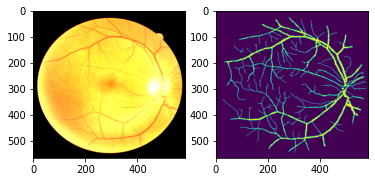

In [9]:
img,mask,fil = dataset[12]
plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(mask[0].numpy())

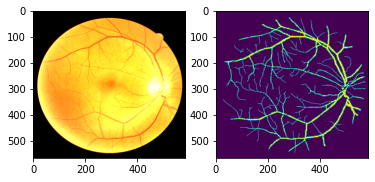

In [10]:
#1.5, 2 - лучший рез(0.757)
img,mask,fil = dataset[12]
plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(mask[0].numpy())

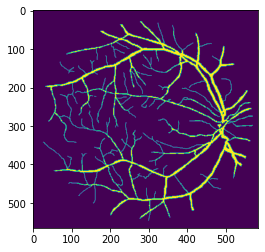

In [11]:
plt.imshow(mask[0].numpy())

In [12]:
np.max(mask[0].numpy())

1.0

In [13]:
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch , out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            #nn.ReLU(inplace=True),
            nn.ELU(),
            #nn.Tanh(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            #nn.Tanh()
            nn.ELU()
            #nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch) 

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))

        x = t.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x



class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = double_conv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        
        
        #self.down4 = down(512, 1024)
        #self.down5 = down(1024, 2048)
        #self.down6 = down(2048, 2048)
        #self.up1 = up(4096, 1024)
        #self.up2 = up(2048, 512)
        #self.up3 = up(1024, 256)
        #self.up4 = up(512, 128)
        #self.up5 = up(256, 64)
        #self.up6 = up(128, 64)
        
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        #x6 = self.down5(x5)
        #x7 = self.down6(x6)
        #
        #x = self.up1(x7, x6)
        #x = self.up2(x, x5)
        #x = self.up3(x, x4)
        #x = self.up4(x, x3)
        #x = self.up5(x, x2)
        #x = self.up6(x, x1)
        #x = self.outc(x)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
#
        x = F.sigmoid(x)
        return x

In [14]:
# Попробуйте использовать различные функции потерь.
def soft_dice_loss(inputs, targets):
        num = targets.size(0)
        m1  = inputs.view(num,-1)
        m2  = targets.view(num,-1)
        intersection = (m1 * m2)
        score = 2. * (intersection.sum(1)+1) / (m1.sum(1) + m2.sum(1)+1)
        score = 1 - score.sum()/num
        return score

In [15]:
def dice_loss(input_, target, filtres):

    iflat = (input_ * filtres) 
    tflat = (target * filtres)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + 1) /(iflat.sum() + tflat.sum() + 1))

In [16]:
from IPython.display import clear_output

In [17]:
model = UNet(3,1)

def train(network, epochs, learning_rate):
    #loss = soft_dice_loss
    loss = dice_loss 
    
    optimizer = t.optim.Adam(network.parameters(), learning_rate)
    
    train_loss_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y, z in dataloader:
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y, z)
                #loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
            train_loss_epochs.append(np.mean(losses))
            losses = []   
        
            clear_output(True)
            print('\rEpoch {0}... (Train) Dice: {1:.3f}'.format(
                        epoch, train_loss_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

Epoch 99... (Train) Dice: 0.180


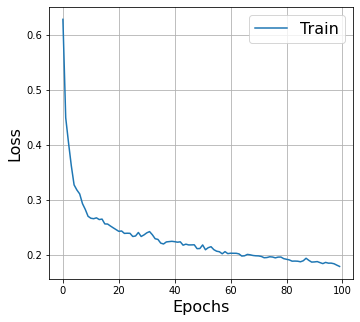

In [18]:
train(model, 100, 0.001)

In [19]:
class TestDataset():
    def __init__(self,path,source_transform,f_trans):
        self.datas = t.load(path)
        self.f_trans = f_trans
        self.s_transform = source_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        filt = data['filter'].numpy()
        img = self.s_transform(img)
        filt = self.f_trans(filt)
        return img, filt
    def __len__(self):
        return len(self.datas)

testset = TestDataset(TEST_PATH, s_trans, f_trans)
testdataloader = t.utils.data.DataLoader(testset,batch_size=1)

In [20]:
#os.makedirs("result")
#!zip -r result.zip result

In [21]:
import skimage.transform
import imageio

In [22]:
"asd/%s.png" %5

'asd/5.png'

In [23]:
model = model.eval()
for ex_id, data in enumerate(testdataloader):
    data = data[0]
    data = t.autograd.Variable(data, volatile=True)
    o = model(data)
    
    source_image = io.imread("drive/MyDrive/test/images/%s_test.tif" % str(ex_id + 1).zfill(2))
    tm = o[0][0].data.cpu().numpy()
    tm = skimage.transform.resize(tm, source_image.shape[:-1])
    tm = (tm > 0.5).astype(int)
    
    imageio.imwrite("drive/MyDrive/test/result/%s.png" % (ex_id + 1), tm)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [24]:
!zip -r drive/MyDrive/test/result.zip drive/MyDrive/test/result

updating: drive/MyDrive/test/result/ (stored 0%)
updating: drive/MyDrive/test/result/1.png (stored 0%)
updating: drive/MyDrive/test/result/2.png (stored 0%)
updating: drive/MyDrive/test/result/3.png (stored 0%)
updating: drive/MyDrive/test/result/4.png (stored 0%)
updating: drive/MyDrive/test/result/5.png (stored 0%)
updating: drive/MyDrive/test/result/6.png (stored 0%)
updating: drive/MyDrive/test/result/7.png (stored 0%)
updating: drive/MyDrive/test/result/8.png (stored 0%)
updating: drive/MyDrive/test/result/9.png (stored 0%)
updating: drive/MyDrive/test/result/10.png (stored 0%)
updating: drive/MyDrive/test/result/11.png (stored 0%)
updating: drive/MyDrive/test/result/12.png (stored 0%)
updating: drive/MyDrive/test/result/13.png (stored 0%)
updating: drive/MyDrive/test/result/14.png (deflated 0%)
updating: drive/MyDrive/test/result/15.png (stored 0%)
updating: drive/MyDrive/test/result/16.png (stored 0%)
updating: drive/MyDrive/test/result/17.png (stored 0%)
updating: drive/MyDrive

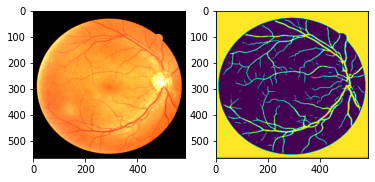

In [25]:
tm=o[0][0].data.cpu().numpy()
plt.subplot(121)
plt.imshow(data[0].data.cpu().permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(tm)